PULMONARY FIBROSIS PROGRESSION PREDICTION

This project explores the use of multimodal data (pulmonary scans images +  clinical features) to predict the progression of the lung capacity in patients with pulmonary fibrosis. The target feature to predict is FVC (Forced Vital Capacity) at un certain week with a level of confidence.
A CNN architecture treating images and a Multi-Layer-Perceptron used for tabular clinic feature will give a feature fusion fro the prediction. Evaluation is performed using PR-AUC and MAE (Mean Absolute Error).

- Dataset: OSIC Pulmonary Fibrosis Progression Dataset
- Tools: TensorFlow, scikit-learn, pandas
- Metrics: MAE (Mean Absolute Error), PR-AUC, feature importance

In [2]:
#Installation of packages
# Download keras applications and efficientnet sources from kaggle
!pip install "C:/Users/SAWADOGO/Documents/Cours/Formations/Projects/CNN & MLP Prediction/keras-team-keras-applications-3b180cb"
!pip install "C:/Users/SAWADOGO/Documents/Cours/Formations/Projects/CNN & MLP Prediction/efficientnet-1.1.0 "
!pip install pydicom 

Processing c:\users\sawadogo\documents\cours\formations\projects\cnn & mlp prediction\keras-team-keras-applications-3b180cb
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for Keras_Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50716 sha256=80340510106a724fd313b747cb65c47f81f1acf4a2588d5e6131004db826f121
  Stored in directory: c:\users\sawadogo\appdata\local\pip\cache\wheels\37\55\24\3dd0dd7438222c217b5399bcee1914559cd9c5b0d6d960573e
Successfully built Keras_Applications
  Attempting uninstall: Keras_Applications
    Found existing installation: Keras_Applications 1.0.8
    Uninstalling Keras_Applications-1.0.8:
      Successfully uninstalled Keras_Applications-1.0.8



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Processing c:\users\sawadogo\documents\cours\formations\projects\cnn & mlp prediction\efficientnet-1.1.0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14139 sha256=a56190e8b534a7bf7112da964d1d56db75b5d76ae4a272ed45c5dc7b329b01e5
  Stored in directory: c:\users\sawadogo\appdata\local\pip\cache\wheels\3f\92\14\2b7fbbce77fa5123d5400ec01fa95c15bc6f7bee778beb8af5
Successfully built efficientnet
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
#Importation of libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import os
import cv2
import random
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import efficientnet.tfkeras as efn
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import pydicom
from pydicom.data import get_testdata_file
import pylibjpeg
print('tensorflow version:', tf.__version__)

tensorflow version: 2.18.0


1. Ensure replicability and setting fixed parameters

In [4]:
def seed_all(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_all(2020)
DATA_PATH = 'C:/Users/SAWADOGO/Documents/Cours/Formations/Projects/CNN & MLP Prediction/dataset'
FEATURES = True
ADV_FEATURES = False
BATCH_SIZE = 10
N_FOLDS = 4
C_SIGMA, C_DELTA = tf.constant(70, dtype='float32'), tf.constant(1000, dtype='float32')
QS = [.05, .50, .95]
IMG_SIZE = 224
RESIZE = 224
SEQ_LEN = 12
CUTOFF = 2
LAMBDA = .8
MDL_VERSION = 'v5'
MODELS_PATH = '.'
MASKED = False
DECAY = False

2. Load dataset and structure exploration

In [5]:
#dataset train
train = pd.read_csv(f'{DATA_PATH}/train.csv')
print(train.head())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker


In [6]:
#dataset test 
test = pd.read_csv(f'{DATA_PATH}/test.csv') 
print(test.head())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker
1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker
2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker
3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker
4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked


In [7]:
#dataset sample submission
subm = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
print(subm.head())

                    Patient_Week   FVC  Confidence
0  ID00419637202311204720264_-12  2000         100
1  ID00421637202311550012437_-12  2000         100
2  ID00422637202311677017371_-12  2000         100
3  ID00423637202312137826377_-12  2000         100
4  ID00426637202313170790466_-12  2000         100


First all all, we have 3 distincts databases. We will use train for training the model, test which have less rows for inner validation and sample submission (sbm) for testing the model.

Secondly, the structure are different. train and test have save feature but it's not the same with subm. The objective is to predict FVC (Forced Vital Capacity) at un certain week with a level of confidence. So, we'll keep FVC and Confidence in subm but we need to have Week and Patient. 

Then, for all the database encode categorial features and normalize numerical ones.


Lastly, the five first element of train is the same patient with different FVC measured at different weeks. So the first FVC measurement or first week for each patient is different. In order to compare the patient evolution we need to know since when each patient is "treated" and then create new features minimum weeks. It would be interesting to know the duration of the "treatment"and relative weeks, and the FVC at this minimum week but now mandatory. minimum weeks will be a new feature to add to the database but we will set flag to activate or desactivate the add of relative weeks and minimum week FVC.

3. Data preprocessing

In [8]:
#delete duplicated rows having same Patient and same Weeks
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])

#Transforming Patient_Week into separate columns
subm['Patient'] = subm['Patient_Week'].apply(lambda x: x.split('_')[0])
subm['Weeks'] = subm['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))

#Merge with test file info
subm =  subm[['Patient','Weeks','Confidence','Patient_Week']]
subm = subm.merge(test.drop('Weeks', axis=1), on='Patient')

#SPLIT column added to distinguish sets
train['SPLIT'] = 'train'
test['SPLIT'] = 'val'
subm['SPLIT'] = 'test'

#Merge train and subm to get our final database
data = pd.concat([train, test, subm], ignore_index=True)
print('train:',  train.shape, 'unique Pats:', train.Patient.nunique(),
      '\ntest:', test.shape,  'unique Pats:', test.Patient.nunique(),
      '\nsubm:', subm.shape,  'unique Pats:', subm.Patient.nunique(),
      '\ndata',  data.shape,  'unique Pats:', data.Patient.nunique())

#Add min_week reference week for each patient
data['min_week'] = data['Weeks']
data.loc[data.SPLIT == 'test', 'min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

#Encode categorial features
data = pd.concat([data, pd.get_dummies(data.Sex), pd.get_dummies(data.SmokingStatus)], axis=1)


train: (1535, 8) unique Pats: 176 
test: (5, 8) unique Pats: 5 
subm: (730, 10) unique Pats: 5 
data (2270, 10) unique Pats: 176


In [9]:
#Add min_week_FVC and min_week if flag FEATURES is activated
if FEATURES:
    base = data.loc[data.Weeks == data.min_week]
    base = base[['Patient', 'FVC']].copy()
    base.columns = ['Patient', 'min_week_FVC']
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    base = base[base.nb == 1]
    base.drop('nb', axis=1, inplace=True)
    data = data.merge(base, on='Patient', how='left')
    data['relative_week'] = data['Weeks'] - data['min_week']
    del base

In [10]:
#if flag FEATURES is desactivated we create encoded statistical features based on categories
if ADV_FEATURES:
    target_cols = ['FVC']
    enc_cols =  [ 
        'Female',
        'Male',
        'Currently smokes',
        'Ex-smoker',
        'Never smoked'
    ]
    for t_col in target_cols:
        for col in enc_cols:
            col_name = f'_{col}_{t_col}_'
            data[f'enc{col_name}mean'] = data.groupby(col)[t_col].transform('mean')
            data[f'enc{col_name}std'] = data.groupby(col)[t_col].transform('std')
            
#Binary indicator added for week 0
data['TC'] = 0
data.loc[data['Weeks'] == 0, 'TC'] = 1
print(data.shape)
print(data.columns)

(2270, 19)
Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'SPLIT', 'Confidence', 'Patient_Week', 'min_week', 'Female', 'Male',
       'Currently smokes', 'Ex-smoker', 'Never smoked', 'min_week_FVC',
       'relative_week', 'TC'],
      dtype='object')


In [11]:
#Normalizing numerical features
feat_cols = [
    'Female', 'Male',
    'Currently smokes', 
    'Ex-smoker', 'Never smoked'
]
scale_cols = [
    'Percent', 
    'Age', 
    'relative_week', 
    'min_week_FVC'
]
scale_cols.extend([x for x in data.columns if 'FVC_mean' in x])
scale_cols.extend([x for x in data.columns if 'FVC_std' in x])
scaler = MinMaxScaler()
data[scale_cols] = scaler.fit_transform(data[scale_cols])
feat_cols.extend(scale_cols)
train = data.loc[data.SPLIT == 'train']
test = data.loc[data.SPLIT == 'val']
subm = data.loc[data.SPLIT == 'test']
del data
print(feat_cols)
train.head()

['Female', 'Male', 'Currently smokes', 'Ex-smoker', 'Never smoked', 'Percent', 'Age', 'relative_week', 'min_week_FVC']


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week,min_week,Female,Male,Currently smokes,Ex-smoker,Never smoked,min_week_FVC,relative_week,TC
0,ID00007637202177411956430,-4,2315,0.236393,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,False,True,False,True,False,0.241456,0.179012,0
1,ID00007637202177411956430,5,2214,0.215941,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,False,True,False,True,False,0.241456,0.234568,0
2,ID00007637202177411956430,7,2061,0.184960,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,False,True,False,True,False,0.241456,0.246914,0
3,ID00007637202177411956430,9,2144,0.201767,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,False,True,False,True,False,0.241456,0.259259,0
4,ID00007637202177411956430,11,2069,0.186580,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,False,True,False,True,False,0.241456,0.271605,0


4. Data generator to load scans images

Data generator provides a batch with images sequences (sequence of CT images) with tabular data for patients in batch. We need ordered CT scans in order to simulate 3D analysis of images. The CNN that will simulate the images output a compressed feature vector that we concatenate with tabular data and feeded to head with dense layers to obtain quantile regression model. Visually we got: 

In [12]:
#Images DICOM (sequence) → CNN (2D or 3D) → feature vector  
#Tabular data         → MLP             → vector  
#                                    ↓
#                     concat([cnn_output, tabular_output])
#                                    ↓
#                          Dense layers (head)
#                                    ↓
#                               Prediction 


Structure of the generated batch. Each batch contains for each patient:

Images: a tensor X_img of form (batch_size, seq_len, img_size, img_size, 3) representing a 3D sequence of CT scans.

Tabular data: X_tab, an array of conventional data such as Age, Sex, etc.

FVC label (expiratory volume) if mode=‘fit’.

In [26]:
#Construction of the batch generator 
class BatchGenerator(Sequence):
    def __init__(self, df, tab_cols,
                 batch_size=8, mode='fit', shuffle=False, 
                 aug=None, resize=None, masked=True, cutoff=2,
                 seq_len=12, img_size=224):
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.resize = resize
        self.masked = masked
        self.cutoff = cutoff
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.tab_cols = tab_cols
        self.on_epoch_end()
    def __len__(self):                              #Configure the total number of batches per epoch
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):                         
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):                   #Function to load a batch 
        batch_size = min(self.batch_size, len(self.df) - index * self.batch_size)
        X_img = np.zeros((batch_size, self.seq_len, self.img_size, self.img_size, 3), dtype=np.float32)
        X_tab = self.df[index * self.batch_size : (index + 1) * self.batch_size][self.tab_cols].values
        pats_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['Patient'].values
        for i, pat_id in enumerate(pats_batch):
            imgs_seq = self.get_imgs_seq(pat_id)
            X_img[i, ] = imgs_seq
        if self.mode == 'fit':
            y = np.array(
                self.df[index * self.batch_size : (index + 1) * self.batch_size]['FVC'].values, 
                dtype=np.float32
            )
            return (np.array(X_img, dtype=np.float32), np.array(X_tab, dtype=np.float32)), np.array(y, dtype=np.float32)
        elif self.mode == 'predict':
            y = np.zeros(batch_size, dtype=np.float32)
            return (np.array(X_img, dtype=np.float32), np.array(X_tab, dtype=np.float32)), np.array(y, dtype=np.float32)
        else:
            raise AttributeError('mode parameter error')
    def load_scan(self, pat_id):                             #Function to load sorted scans (DICOM format) for a given patient
        if self.mode == 'fit':
            path = f'{DATA_PATH}/train/{pat_id}'
        elif self.mode == 'predict':
            path = f'{DATA_PATH}/test/{pat_id}'
        else:
            raise AttributeError('mode parameter error')
        file_names = sorted(os.listdir(path), key=lambda x: int(os.path.splitext(x)[0]))
        idxs = [
            int(i * len(file_names) / (self.seq_len + 2 * self.cutoff)) #select seq_len images with cutoff on each side
            for i in range(self.seq_len + 2 * self.cutoff)
        ]
        slices = [
            pydicom.dcmread(path + '/' + file_names[idx])
            for idx in idxs[self.cutoff:-self.cutoff]
            ]
        if len(slices) < self.seq_len:
            for i in range(self.seq_len - len(slices)):
                slices.append(
                    pydicom.dcmread(path + '/' + os.listdir(path)[-1])
                )
        return slices
    def get_pixels_hu(self, scans):                          #Function to combine treated images scans with their metadata (pixelization)
        image = np.stack([s.pixel_array.astype(float) for s in scans])
        image = image.astype(np.int16)
        image[image == -2000] = 0
        intercept = scans[0].RescaleIntercept
        slope = scans[0].RescaleSlope
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
        image += np.int16(intercept)
        return np.array(image, dtype=np.int16)
    def get_imgs_seq(self, pat_id):                          #Function for images DICOM format treatment
        seq_imgs = []                   
        slices = self.load_scan(pat_id)         #load images DICOM
        scans = self.get_pixels_hu(slices)      #call fro pixelization 
        for img_idx in range(self.seq_len):
            img = scans[img_idx]
            if self.masked:                         
                mask = self.get_lungs_mask(img)     #call of mask application function
                img[mask == False] = img.min()
            if self.resize:                                    #resize, normalization
                img = cv2.resize(img, (self.resize, self.resize))
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img = np.repeat(img[..., np.newaxis], 3, -1)
            seq_imgs.append(img)                 
        return np.array(seq_imgs).astype(np.float32)
    def get_lungs_mask(self, img):                      #Mask application function 
        mask = img < -200
        mask = clear_border(mask)
        mask = label(mask)
        areas = [r.area for r in regionprops(mask)]
        areas.sort()
        if len(areas) > 2:
            for region in regionprops(mask):
                if region.area < areas[-2]:
                    for coordinates in region.coords:
                        mask[coordinates[0], coordinates[1]] = 0
        return mask > 0

_init_ configure all the hyperparameters.

df: dataframe containing list of patients, their tabular data and FVC.

masked = True:  indicating a lung mask is applied to slices (different images obtained from a scan), focusing only on lung slices.

seq_len: number of CT scans extracted per patient (many CT scans per patient, so we define a fixed number for all patient)

cutoff: first/last images are ignored to avoid uninformative slices.

In [27]:
#cross-validation ensuring that the same patient is never in two different folds.
gkf = GroupKFold(n_splits=N_FOLDS)
train['fold'] = -1
for i, (train_idx, val_idx) in enumerate(gkf.split(train, groups=train['Patient'])):
    train.loc[val_idx, 'fold'] = i

With our batch generator, we generate two databases (combining CT image sequences (DICOM) and tabular data), train_gen for model training, val_gen for validation and test_gen for testing.

In [28]:
train_gen = BatchGenerator(
    df=train.loc[train['fold'] != 0], 
    tab_cols=feat_cols,
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=True, 
    aug=None, 
    resize=RESIZE,
    masked=MASKED,
    cutoff=CUTOFF,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE
)
val_gen = BatchGenerator(
    df=train.loc[train['fold'] == 0],
    tab_cols=feat_cols,
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=False, 
    aug=None,
    resize=RESIZE,
    masked=MASKED,
    cutoff=CUTOFF,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE
)

test X img:  (10, 12, 224, 224, 3)
test X tab:  (10, 9)
test y:  (10,)


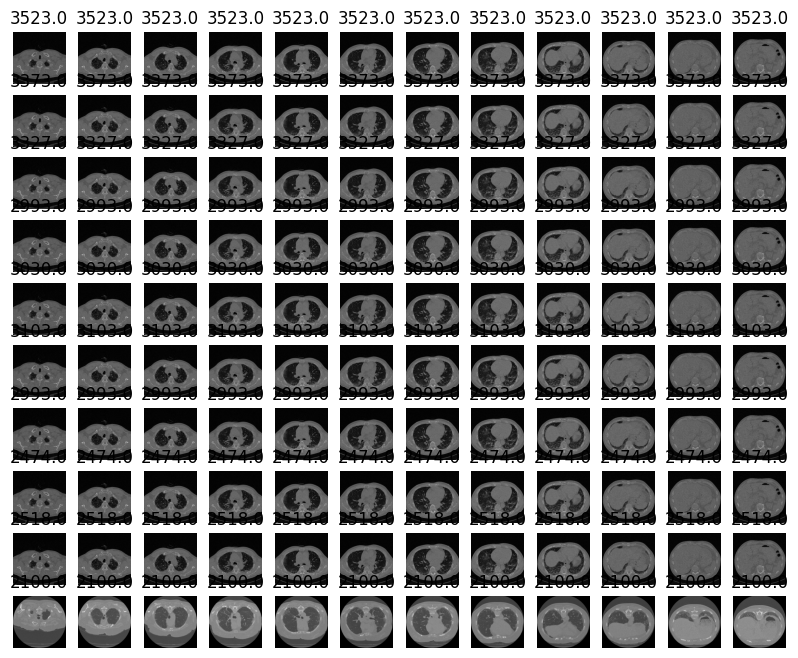

[3523. 3373. 3327. 2993. 3030. 3103. 2993. 2474. 2518. 2100.]


In [29]:
#Visualization of a single batch
(Xt_img, Xt_tab), yt = val_gen.__getitem__(0)
print('test X img: ', Xt_img.shape)
print('test X tab: ', Xt_tab.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(10, 8), nrows=BATCH_SIZE, ncols=SEQ_LEN)
for j in range(BATCH_SIZE):
    for i in range(SEQ_LEN):
        axes[j, i].imshow(Xt_img[j][i])
        axes[j, i].axis('off')
        axes[j, i].set_title(yt[j])
plt.show()
print(yt)

5. Model training

The process of model training is: 

Creation of a multimodal model that take, Input 1: an image sequence (CT-scan) - processed by a CNN (EfficientNetB0 with his weight),Input 2: tabular data, and Fusion the two types of features to Output the prediction for the optimization algorithm (Adam). 

The optimization is divided by batch and epoch. 

At each batch the loss function is calculated and a backpropagation is performed to adjust the weights. 

At the end of each epoch the model is evaluated on the validation set with Keras by calculating the loss on validation data and performing a score evaluation. These inputs (validation loss and score) are introduced in the model for the next epoch via callbacks. 

After training the model is evaluated with a metric.

In [35]:
#Function score for evaluation after an epoch
def score(y_true, y_pred):                     
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = (y_pred[:, 2] - y_pred[:, 0]) / 2
    fvc_pred = y_pred[:, 1]
    sigma_clip = tf.maximum(sigma, C_SIGMA)
    delta = tf.abs(y_true - fvc_pred)
    delta = tf.minimum(delta, C_DELTA)
    sq2 = tf.sqrt(tf.dtypes.cast(2, dtype=tf.float32))
    metric = sq2 * (delta / sigma_clip) + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)

#quantile loss function
def qloss(y_true, y_pred):                          
    q = tf.constant(np.array([QS]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q - 1) * e)
    return K.mean(v)

#loss function for each batch which
def mloss(lmbd):                                     
    def loss(y_true, y_pred):
        return lmbd * qloss(y_true, y_pred) + (1 - lmbd) * score(y_true, y_pred)        #a mix between quantile loss and score
    return loss

#Learning rate callback
def get_lr_callback(batch_size=10, epochs=100, warmup=.3, plot=False):
    lr_start = 0.0001
    lr_max = 0.001 * batch_size
    lr_min = 0.00001
    lr_ramp_ep = epochs * warmup
    lr_sus_ep = 0
    lr_decay = 0.97
    def lr_scheduler(epoch):                        #Plans the learning rate in 3 phases:
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max
            else:
                lr = (lr_max - lr_min) * lr_decay ** (epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            return lr
    if plot == False:
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=False)
        return lr_callback 
    else: 
        return lr_scheduler

In [31]:
# Callback that displays score and loss every 5 epochs:
class LogPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_score = []        
    def on_epoch_end(self, epoch, logs=None):
        self.val_score.append(logs['val_score'])
        if epoch % 5 == 0 or epoch == (EPOCHS - 1):
            print(
                f"\tEPOCH {epoch + 1} | loss: {logs['loss']:.2f} | score: {logs['score']}",
                f"| val loss: {logs['val_loss']:.2f} | val score: {logs['val_score']}"
            )
    def on_train_end(self, lowest_val_loss, logs=None):
        best_epoch = np.argmin(self.val_score)
        best_score = self.val_score[best_epoch]
        print(f'best model at epoch {best_epoch + 1} | score: {best_score}')

In [32]:
#Multimodal model 
def get_model(inputs_seq_shape, inputs_tab_shape, units=128, mult=2, prob=.4, lmbd=.8):
    bottleneck = efn.EfficientNetB0(
        weights='C:/Users/SAWADOGO/Documents/Cours/Formations/Projects/CNN & MLP Prediction/efficientnetweights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5', 
        include_top=False, 
        pooling='avg'
    )
    bottleneck = M.Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
    inputs_seq = L.Input(shape=(*inputs_seq_shape, ))
    inputs_tab = L.Input(shape=(inputs_tab_shape, ))
    x = L.TimeDistributed(bottleneck)(inputs_seq) 
    x = L.TimeDistributed(L.BatchNormalization())(x)
    x = L.GlobalMaxPooling3D()(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(prob)(x)
    x = L.Dense(int(mult * units), activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(prob)(x)
    comb_inputs = L.concatenate([inputs_tab, x]) # concatenate features from EfficientNet network and tabular data
    x = L.Dense(units, activation='relu')(comb_inputs)
    x = L.Dropout(prob)(x)
    x = L.Dense(units, activation='relu')(x)
    x = L.Dropout(prob)(x)
    preds = L.Dense(3, activation='linear')(x)
    model = M.Model([inputs_seq, inputs_tab], preds)
    model.compile(
        loss=mloss(lmbd),
        optimizer=Adam(learning_rate=0.01), 
        metrics=[score]
    )
    return model

In [33]:
#Here we set parameters to optimize and monitor the training
EPOCHS = 400                        #model will be trained during 400 epochs
model_file = f'{MODELS_PATH}/model_{MDL_VERSION}.keras' #Defines the path where the best model will be saved during training

earlystopper = EarlyStopping(           #Stops training if the val_score metric no longer improves after 20 consecutive epochs
        monitor='val_score', 
        patience=20, 
        verbose=0,
        mode='min'
        )
modelsaver = ModelCheckpoint(          #Saves the best model each time val_score improves
    model_file, 
    monitor='val_score', 
    verbose=1, 
    save_best_only=True,
    mode='min'
)
lrreducer = ReduceLROnPlateau(          #Reduces learning rate automatically if val_score do not improve
    monitor='val_score',
    factor=.1,
    patience=10,
    verbose=0,
    min_lr=1e-5,
    mode='min'
)
callbacks = [earlystopper, modelsaver, LogPrintingCallback()]

#Function that adjusts the learning rate to avoid overfitting or improve convergence.
if DECAY:
    lr_scheduler_plot = get_lr_callback(batch_size=10, plot=True)
    xs = [i for i in range(EPOCHS)]
    y = [lr_scheduler_plot(x) for x in xs]
    plt.plot(xs, y)
    plt.title(f"lr schedule from {y[0]:.3f} to {max(y):.3f} to {y[-1]:.5f}")
    plt.show()
    callbacks.append(get_lr_callback(BATCH_SIZE))
else:
    callbacks.append(lrreducer)

In [ ]:
#Training 
model = get_model(
    inputs_seq_shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3), 
    inputs_tab_shape=len(feat_cols), 
    units=128, mult=4, prob=0, lmbd=LAMBDA
)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    verbose=1
)

Epoch 1/400


c:\Users\SAWADOGO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_954']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


In [ ]:
#Metric to evaluate the model after training
def metric(y_true, y_pred, pred_std):
    clip_std = np.clip(pred_std, 70, 9e9)  
    delta = np.clip(np.abs(y_true - y_pred), 0 , 1000)  
    return np.mean(-1 * (np.sqrt(2) * delta / clip_std) - np.log(np.sqrt(2) * clip_std))

6. Prediction

In [ ]:
val_gen.mode = 'predict'
y_pred = model.predict(val_gen, verbose=1)
y_true = val_gen.df['FVC'].values

# y_pred[:, 0] = lower bound
# y_pred[:, 1] = predicted FVC
# y_pred[:, 2] = upper boundfrom your_module import metric  # si elle n'est pas déjà dans le notebook

score_val = metric(y_true, y_pred_mean, pred_std)
print(f"Validation metric (offline): {score_val:.4f}")

pred_std = (y_pred[:, 2] - y_pred[:, 0]) / 2
y_pred_mean = y_pred[:, 1]
score_val = metric(y_true, y_pred_mean, pred_std)
print(f"Validation metric (offline): {score_val:.4f}")

In [23]:
import pydicom.config

print("✅ Pydicom pixel data handlers activés :")
for handler in pydicom.config.pixel_data_handlers:
    print(f" - {handler.__name__}")

✅ Pydicom pixel data handlers activés :
 - pydicom.pixel_data_handlers.numpy_handler
 - pydicom.pixel_data_handlers.gdcm_handler
 - pydicom.pixel_data_handlers.pillow_handler
 - pydicom.pixel_data_handlers.jpeg_ls_handler
 - pydicom.pixel_data_handlers.pylibjpeg_handler
 - pydicom.pixel_data_handlers.rle_handler
